In [1]:
%matplotlib inline

In [2]:
import glob
import os.path as op
import os as os
import nibabel as nib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

# Plotting
import matplotlib.pyplot as plt
from nilearn import plotting
import seaborn as sns
sns.set(context="poster", style="ticks", font="Arial")

## Define some experiment-specific info

In [42]:
exp_name = 'mvpa_raw'
smoothing = 'unsmoothed'
regspace = 'epi'
smoothing_fwhm = 0
standardize = True
tr_shift_test_list = [0, 2, 4, 6, 8, 10, 12]

basedir = '/Volumes/group/awagner/sgagnon/AP'
analydir = op.join(basedir, 'analysis/{trial_type}').format(trial_type=exp_name)
subjfile = op.join(analydir, 'notebooks/subj_info.csv')
subj_info = pd.read_csv(subjfile)

# outtrials = op.join(analydir, '{subid}', 'trial_estimates',
#                     '{subid}_{output}_{time}s_trial_ovr_estimates_{mask}_byrep.csv')

# FOR ALL OTHER LOGITS + VTC (2-class -- just to check if "word" attention might bias):
# outtrials = op.join(analydir, '{subid}', 'trial_estimates',
#                     '{subid}_{output}_{time}s_trial_ovr_estimates_{mask}_byrep_filtartloc_scalewithinrun.csv')

# FOR VTC LOGITS (3-class):
outtrials = op.join(analydir, '{subid}', 'trial_estimates',
                    '{subid}_{output}_{time}s_trial_ovr_estimates_3class_{mask}_byrep_filtartloc_scalewithinrun.csv')

# outtrials = op.join(analydir, '{subid}', 'trial_estimates',
#                     '{subid}_{output}_{time}s_trial_ovr_estimates_3class_{mask}_byrep_filtartloc_equalizecounts.csv')

artifacts = op.join(analydir, '{subid}', 'preproc', 'run_{run}', 'artifacts.csv')

# Combine paths into dictionary (facilitate passing i/o of funcs)
paths = dict(outtrials=outtrials, 
             analydir=analydir,
             artifacts=artifacts)

In [43]:
subj_info.group.value_counts()

stress     22
control    22
Name: group, dtype: int64

## Read in classification data

In [46]:
output = 'logit'
mask_name = 'bilat-parahipp_fusi_inftemp_nohipp' # VTC (original)
# mask_name = 'bilat-fusi_inftemp_nohipp' # VYC without phc (test to see if phc necessary)
# mask_name = 'lh-inferiorparietal' # inferior parietal (angular + other)
# mask_name = 'bilat-hippocampus' # exploratory: evidence for categorical reinstatement in hipp too?
# mask_name = 'lh-DefaultC_IPL' # exploratory: what if we restict just to angular region?

print mask_name 

evidence_group = pd.DataFrame()
for subid in subj_info.subid:

    evidence = pd.DataFrame()
    for time in tr_shift_test_list:
        evidence_time = pd.read_csv(paths['outtrials'].format(subid=subid, output=output, 
                                                              time=time, mask=mask_name))
        evidence_time['time'] = time
        evidence_time['subid'] = subid
        evidence = evidence.append(evidence_time, ignore_index=True)

    evidence = evidence.rename(columns={'Unnamed: 0': 'condition'}).reset_index()
    evidence_group = evidence_group.append(evidence, ignore_index=True)


bilat-parahipp_fusi_inftemp_nohipp


In [47]:
evidence_group.loc[evidence_group.time == 0].groupby(['subid', 'condition']).count().head()

index  face  object  place  tr  onset  run  time
subid condition                                                     
ap100 CR-0             63    63      63     63  63     63   63    63
      FA-0             16    16      16     16  16     16   16    16
      M-2              18    18      18     18  18     18   18    18
      M-4              14    14      14     14  14     14   14    14
      itemhit_lo-2     17    17      17     17  17     17   17    17

In [48]:
evidence_group = evidence_group.merge(subj_info)
evidence_group.head()

,index,condition,face,object,place,tr,onset,run,time,subid,group
0,0,sourcemiss_hi-4,-2.423333,6.498398,-6.634973,1.0,0.0191,1.0,0,ap100,control
1,1,CR-0,3.903201,-3.432970,-0.182527,6.0,10.7129,1.0,0,ap100,control
2,2,sourcehit-2,6.809258,1.399707,-9.264720,10.0,19.8642,1.0,0,ap100,control
3,3,sourcehit-2,-1.613396,-3.539275,6.803715,15.0,29.3132,1.0,0,ap100,control
4,4,sourcehit-2,-6.580058,-1.326757,8.430978,21.0,40.6786,1.0,0,ap100,control


In [312]:
## if 2-category and need to rename
# evidence_group.rename(columns={'face': 'place'}, inplace=True)
# evidence_group.head()

## Output onset files for logit-modulated univariate analysis

This analysis explores where in the brain is modulated by increased reinstatement 

In [153]:
dt = pd.read_csv('/Volumes/group/awagner/sgagnon/AP/analysis/mvpa/notebooks/ap_behav.csv')
dt.onset = dt.onset_adj
dt = dt.loc[:,['subid', 'run', 'trial', 'onset', 'obj_conditions', 'mem_conditions']]

In [154]:
# average logits over a window for each trial
data = evidence_group.loc[:,['subid', 'group', 'run', 'onset', 'time', 'place', 'condition']]
data.sort_values(by=['subid', 'run', 'onset', 'time'], inplace=True)
data_p = data.pivot_table(index=['group', 'subid', 'run', 'onset', 'condition'], columns='time', values='place').reset_index()
data_p['avg_logit'] = data_p[[4,6,8,10]].mean(axis=1)

# merge with onset file
data_p.onset = data_p.onset.round()
dt.onset = dt.onset.round()
data = data_p.merge(dt, on=['subid', 'run', 'onset'], how='outer') # outer join to keep nuisance/shock trials 
# (note that dt also has subjects that we're tossing for fMRI)
print data_p.shape
print dt.shape
print data.shape
data.head()

(5171, 13)
(11789, 6)
(11789, 16)


time,group,subid,run,onset,condition,0,2,4,6,8,10,12,avg_logit,trial,obj_conditions,mem_conditions
0,control,ap100,1,11,CR,-0.170266,-1.018969,-3.787483,-6.946018,-7.847842,-5.117977,4.856460,-5.924830,2,new,CR
1,control,ap100,1,20,sourcehit,-10.059163,NaN,NaN,4.498670,NaN,8.414237,6.642507,6.456453,3,old,sourcehit
2,control,ap100,1,29,sourcehit,6.626048,NaN,NaN,NaN,-0.551006,NaN,11.208046,-0.551006,4,old,sourcehit
3,control,ap100,1,41,sourcehit,8.218337,NaN,NaN,3.020099,NaN,0.753717,NaN,1.886908,5,old,sourcehit
4,control,ap100,1,50,sourcehit,NaN,NaN,-2.396999,NaN,-1.868044,NaN,-5.878458,-2.132522,6,old,sourcehit


In [155]:
data.mem_conditions.unique()

array(['CR', 'sourcehit', 'sourcemiss_hi', 'M', 'FA', 'itemhit_lo',
       'nuisance'], dtype=object)

In [116]:
# make old/new that includes "nuisance" for no responses
data = data.replace({'mem_conditions': {'CR': 'new', 'FA': 'new',
                                        'sourcehit': 'old', 'itemhit_lo': 'old',
                                        'M': 'old', 'sourcemiss_hi': 'old'}})

In [83]:
# z-score within condition/run
zscore = lambda x: (x-x.mean()) / x.std()
data['place_scaled'] = data.groupby(['subid', 'run', 'mem_conditions']).avg_logit.transform(zscore)

In [27]:
# output_filename = 'AP_scene_logit_nohipp.csv'
output_filename = 'AP_scene_logit_nohipp_2class.csv'
output_dir = '/Volumes/group/awagner/sgagnon/AP/data'

for subid in subj_info.subid:
    print subid
    
    dsub = data[(data.subid == subid)]

    ddesign = pd.DataFrame({'run': dsub.run,
                            'condition': dsub.mem_conditions,
                            'onset': dsub.onset,
                            'duration': 0,
                            'value': 1})

    # Add parametric modulators
    dsub_no_nuisance = dsub.query('mem_conditions != "nuisance"')
    ddesign = ddesign.append(pd.DataFrame({'run': dsub_no_nuisance.run,
                                            'condition': dsub_no_nuisance.mem_conditions + '_scene',
                                            'onset': dsub_no_nuisance.onset,
                                            'duration': 0,
                                            'value': dsub_no_nuisance.place_scaled}), ignore_index=True)
    
    
    # add in nuisance to deal with NRs
    for run in ddesign.run.unique():
        ddesign = ddesign.append({'run': run,
                                  'condition': 'nuisance',
                                  'onset': 221*2-4, 
                                  'duration': 4,
                                  'value': 1}, ignore_index=True)
    
    
    sub_output_dir = op.join(output_dir, subid, 'design')
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)
        print 'Making directory'
    
    ddesign.to_csv(op.join(sub_output_dir, output_filename), index=False)

ap100
ap101
ap102
ap103
ap104
ap105
ap107
ap108
ap109
ap110
ap111
ap113
ap114
ap115
ap116
ap117
ap118
ap119
ap120
ap121
ap122
ap150
ap152
ap153
ap154
ap155
ap157
ap158
ap159
ap160
ap161
ap162
ap163
ap164
ap165
ap166
ap167
ap168
ap169
ap170
ap171
ap172
ap173
ap174



## Integrate artifact detection to screen out noisy samples

In [49]:
artifacts_group = pd.DataFrame()
for subid in evidence_group.subid.unique():
    run_list = evidence_group.loc[evidence_group.subid == subid].run.unique()
    
    for run in run_list:
        run_arts = pd.read_csv(paths['artifacts'].format(subid=subid, run=str(int(run))))
        run_arts['tr'] = np.arange(1,len(run_arts)+1).astype(float)
        run_arts['subid'] = subid
        run_arts['run'] = run
        
        artifacts_group = artifacts_group.append(run_arts, ignore_index=True)

In [50]:
artifacts_group.head()

,intensity,motion,spikes,tr,subid,run
0,0,0,0,1.0,ap100,1.0
1,0,0,0,2.0,ap100,1.0
2,0,0,0,3.0,ap100,1.0
3,0,0,0,4.0,ap100,1.0
4,0,0,0,5.0,ap100,1.0


### Now merge w/the classification data

In [51]:
evidence_group.shape # longer (for non-equalized trial counts) because of some duplicate TRs across conditions (eg end/beginning of trials)
# for equalized trial counts: 27986
# for regular: 74746

(74746, 11)

In [52]:
artifacts_group.shape
# 55913

(58123, 6)

In [53]:
evidence_group = evidence_group.merge(artifacts_group, on=['subid', 'run', 'tr'], how='left').reset_index()

In [54]:
print evidence_group.shape
evidence_group.head()

(74746, 15)


,level_0,index,condition,face,object,place,tr,onset,run,time,subid,group,intensity,motion,spikes
0,0,0,sourcemiss_hi-4,-2.423333,6.498398,-6.634973,1.0,0.0191,1.0,0,ap100,control,0,0,0
1,1,1,CR-0,3.903201,-3.432970,-0.182527,6.0,10.7129,1.0,0,ap100,control,0,0,0
2,2,2,sourcehit-2,6.809258,1.399707,-9.264720,10.0,19.8642,1.0,0,ap100,control,0,0,0
3,3,3,sourcehit-2,-1.613396,-3.539275,6.803715,15.0,29.3132,1.0,0,ap100,control,0,0,0
4,4,4,sourcehit-2,-6.580058,-1.326757,8.430978,21.0,40.6786,1.0,0,ap100,control,0,0,0


In [58]:
artifact_counts = evidence_group.groupby(['subid', 'group']).sum().reset_index()
artifact_counts.groupby(['group']).mean()

,level_0,index,face,object,place,tr,onset,run,time,intensity,motion,spikes
group,,,,,,,,,,,,
control,3.392791e+07,1.506547e+06,-422.169724,-561.029322,-471.186827,186982.727273,361778.744441,6064.545455,10414.090909,16.090909,0.136364,0.0
stress,9.304686e+07,1.383685e+06,-473.190663,-568.842318,-484.159234,179396.636364,347140.257482,5752.727273,9971.181818,19.045455,1.181818,0.0


### How many samples have motion > 1 mm?

In [59]:
artifact_counts.loc[artifact_counts.motion > 1]

,subid,group,level_0,index,face,object,place,tr,onset,run,time,intensity,motion,spikes
19,ap121,control,59590566,1554966,-535.641050,-625.917077,-624.942028,189798.0,367281.0939,6174.0,10584,4,3,0
21,ap150,stress,61264735,1352190,-611.852814,-626.582144,-718.529683,173628.0,335702.8542,5691.0,9870,8,4,0
24,ap154,stress,70472633,1386945,-470.759013,-450.606616,-475.853295,183428.0,355134.0863,5810.0,9996,39,22,0


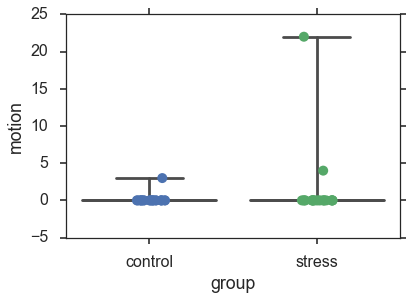

In [60]:
sns.boxplot(x = 'group', y='motion', data=artifact_counts)
sns.stripplot(x = 'group', y='motion', data=artifact_counts, jitter=True, size=10)

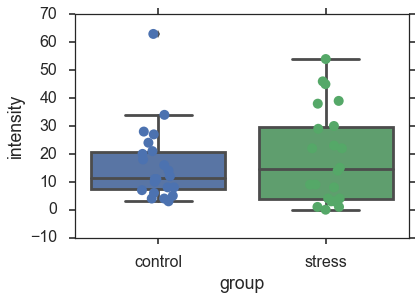

In [61]:
sns.boxplot(x = 'group', y='intensity', data=artifact_counts)
sns.stripplot(x = 'group', y='intensity', data=artifact_counts, jitter=True, size=10)

## Remove trials with motion > 1 mm, or intensity > 1

### First remove just TRs

In [62]:
evidence_proc = evidence_group.loc[(evidence_group.motion == 0) &
                                   (evidence_group.intensity == 0)]
evidence_proc.shape

(73959, 15)

### Remove this percentage of TRs:

In [63]:
len(evidence_group)

74746

In [64]:
print str((len(evidence_group) - len(evidence_proc)) / float(len(evidence_group)) * 100) + ' %'

1.05289915179 %


**Equalize trial counts**: ~1% of TRs are noisy... probably doesn't affect anything...

### Put the data in longform

In [65]:
df = pd.melt(evidence_proc, id_vars=['condition', 'tr', 'onset', 'run', 'time', 'subid', 'group'],
             value_vars=['face', 'object', 'place'], 
             var_name='category', value_name=output)
df.head()

,condition,tr,onset,run,time,subid,group,category,logit
0,sourcemiss_hi-4,1.0,0.0191,1.0,0,ap100,control,face,-2.423333
1,CR-0,6.0,10.7129,1.0,0,ap100,control,face,3.903201
2,sourcehit-2,10.0,19.8642,1.0,0,ap100,control,face,6.809258
3,sourcehit-2,15.0,29.3132,1.0,0,ap100,control,face,-1.613396
4,sourcehit-2,21.0,40.6786,1.0,0,ap100,control,face,-6.580058


### Remove trials with bad samples

In [66]:
evidence_group.loc[(evidence_group.motion > 0) |
                   (evidence_group.intensity > 0)].subid.value_counts()

ap120    63
ap152    54
ap154    49
ap157    46
ap164    45
ap165    38
ap102    34
ap167    30
ap169    29
ap100    28
ap104    27
ap115    24
ap162    23
ap153    22
ap174    22
ap109    21
ap119    20
ap107    18
ap122    16
ap173    15
ap105    14
ap172    14
ap113    12
ap114    11
ap150    11
ap116    11
ap110    10
ap155     9
ap166     9
ap118     8
ap117     8
ap158     7
ap111     6
ap121     5
ap108     5
ap159     4
ap168     4
ap101     4
ap103     3
ap171     3
ap161     3
ap163     1
ap160     1
Name: subid, dtype: int64

In [67]:
avg_interval = [4,6,8,10]
avg_interval_lab = '46810'

In [68]:
# df.sort(columns=['subid', 'run', 'onset', 'time'], inplace=True)
data_p = df.pivot_table(index=['group', 'subid', 'run', 'onset', 'condition', 'category'], columns='time', values='logit').reset_index()
data_p['avg_logit'] = data_p[avg_interval].mean(axis=1, skipna=False) # see if null in any of our TRs of interest
data_p.head()

time,group,subid,run,onset,condition,category,0,2,4,6,8,10,12,avg_logit
0,control,ap100,1.0,0.0191,sourcemiss_hi-4,face,-2.423333,-0.385312,-1.657511,-0.461869,3.046599,4.391805,1.240766,1.329756
1,control,ap100,1.0,0.0191,sourcemiss_hi-4,object,6.498398,5.214719,2.106095,-4.898674,-3.753721,-3.559239,-1.991269,-2.526385
2,control,ap100,1.0,0.0191,sourcemiss_hi-4,place,-6.634973,-6.316287,-1.492246,2.588891,-1.034470,-0.641691,-1.102607,-0.144879
3,control,ap100,1.0,10.7129,CR-0,face,3.903201,1.295241,1.546018,4.994777,6.359166,2.788228,-3.314593,3.922047
4,control,ap100,1.0,10.7129,CR-0,object,-3.432970,-2.109885,-0.627178,0.647714,1.071187,1.822644,-1.811745,0.728592


In [69]:
df_logit = data_p.loc[~data_p.avg_logit.isnull()].reset_index()
# conditions = pd.DataFrame(df_logit.condition.str.split('-').tolist(), columns=['cond', 'reps'])
# df_logit = df_logit.join(conditions)
df_logit.head()

time,index,group,subid,run,onset,condition,category,0,2,4,6,8,10,12,avg_logit
0,0,control,ap100,1.0,0.0191,sourcemiss_hi-4,face,-2.423333,-0.385312,-1.657511,-0.461869,3.046599,4.391805,1.240766,1.329756
1,1,control,ap100,1.0,0.0191,sourcemiss_hi-4,object,6.498398,5.214719,2.106095,-4.898674,-3.753721,-3.559239,-1.991269,-2.526385
2,2,control,ap100,1.0,0.0191,sourcemiss_hi-4,place,-6.634973,-6.316287,-1.492246,2.588891,-1.034470,-0.641691,-1.102607,-0.144879
3,3,control,ap100,1.0,10.7129,CR-0,face,3.903201,1.295241,1.546018,4.994777,6.359166,2.788228,-3.314593,3.922047
4,4,control,ap100,1.0,10.7129,CR-0,object,-3.432970,-2.109885,-0.627178,0.647714,1.071187,1.822644,-1.811745,0.728592


### Percent of trials tossed

In [104]:
# Number of trials tossed/subject
art_num = pd.DataFrame(pd.DataFrame(data_p.loc[(data_p.avg_logit.isnull()) & 
                                  (data_p.category == "place") &
                                  (data_p.condition.isin(['sourcehit-2', 'sourcehit-4']))].subid.value_counts().rename('art_num'))).reset_index()

# Number of good trials/subject
trial_num = pd.DataFrame(data_p.loc[(data_p.category == "place") &
                                    (data_p.condition.isin(['sourcehit-2', 'sourcehit-4']))].subid.value_counts().rename('trial_num')).reset_index()

In [109]:
art_prop = art_num.merge(trial_num, how='outer')
art_prop.fillna(0, inplace=True)
art_prop['prop'] = art_prop.art_num / art_prop.trial_num

In [114]:
art_prop.describe()

,art_num,trial_num,prop
count,44.000000,44.000000,44.000000
mean,1.386364,67.909091,0.021701
std,1.279824,34.785601,0.023067
min,0.000000,8.000000,0.000000
25%,0.000000,42.750000,0.000000
50%,1.000000,67.000000,0.016340
75%,2.000000,86.000000,0.028782
max,4.000000,148.000000,0.090909


In [115]:
# remaining trials
data = df_logit.query('category == "place"')
counts = data.groupby(['subid', 'group']).count().reset_index()
counts.groupby(['group']).index.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,22.0,242.181818,7.63224,218.0,239.50,244.5,247.0,250.0
stress,22.0,231.000000,12.09880,196.0,230.25,233.5,239.5,244.0


In [75]:
df_logit.head()

time,index,group,subid,run,onset,condition,category,0,2,4,6,8,10,12,avg_logit
0,0,control,ap100,1.0,0.0191,sourcemiss_hi-4,face,-2.423333,-0.385312,-1.657511,-0.461869,3.046599,4.391805,1.240766,1.329756
1,1,control,ap100,1.0,0.0191,sourcemiss_hi-4,object,6.498398,5.214719,2.106095,-4.898674,-3.753721,-3.559239,-1.991269,-2.526385
2,2,control,ap100,1.0,0.0191,sourcemiss_hi-4,place,-6.634973,-6.316287,-1.492246,2.588891,-1.034470,-0.641691,-1.102607,-0.144879
3,3,control,ap100,1.0,10.7129,CR-0,face,3.903201,1.295241,1.546018,4.994777,6.359166,2.788228,-3.314593,3.922047
4,4,control,ap100,1.0,10.7129,CR-0,object,-3.432970,-2.109885,-0.627178,0.647714,1.071187,1.822644,-1.811745,0.728592


In [419]:
data = df_logit
data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_bilat-parahipp_fusi_inftemp_allcat_byreps_avg_'+avg_interval_lab+'_filtartloc_equalizetrials.csv')

# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_bilat-fusi_inftemp_nohipp_allcat_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_bilat-hippocampus_allcat_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_inferiorparietal_allcat_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_allcat_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')

In [144]:
data = df_logit.query('category == "place"')
data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_bilat-fusi_inftemp_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_bilat-hippocampus_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_inferiorparietal_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')

In [227]:
data = df_logit.query('cond == "sourcehit" & category == "place"')
data_grouped = data.groupby(['subid', 'group']).mean().reset_index()

g = sns.factorplot(x='group', y='avg_logit', 
               units='subid', ci=68, kind='bar', 
               palette=['dodgerblue', 'orange'], 
               data=data_grouped)
g.set_ylabels('Reinstatement strength (logit)')

# plt.savefig('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_bilat-fusi_inftemp_sourcehit_place_avg_filtartloc_scalewithinrun.png')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_bilat-fusi_inftemp_sourcehit_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')
# plt.savefig('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_bilat-hippocampus_sourcehit_place_avg_filtartloc_scalewithinrun.png')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_bilat-hippocampus_sourcehit_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')
# plt.savefig('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_inferiorparietal_sourcehit_place_avg_filtartloc_scalewithinrun.png')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_inferiorparietal_sourcehit_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')
# plt.savefig('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_sourcehit_place_avg_filtartloc_scalewithinrun.png')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_sourcehit_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')

UndefinedVariableError: name 'cond' is not defined

### Is place evidence for source hits reduced if only 2 study repetitions?

#### Average some columns

/Users/steph-backup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


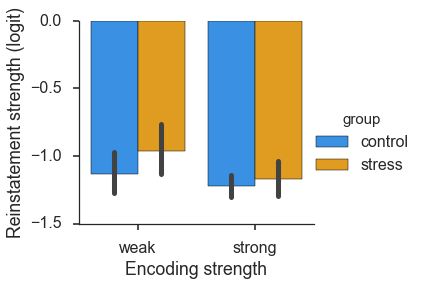

In [139]:
data = df_logit.query('cond == "sourcehit" & category == "place"')
data['strength'] = 'nan'
data.ix[data.reps == '2', 'strength'] = 'weak'
data.ix[data.reps == '4', 'strength'] = 'strong'

data_grouped = data.groupby(['subid', 'strength', 'group']).mean().reset_index()

g = sns.factorplot(x='strength', y='avg_logit', hue='group', 
               units='subid', ci=68, kind='bar', order = ['weak', 'strong'],
               palette=['dodgerblue', 'orange'], aspect=1.2,
               data=data_grouped)
g.set_ylabels('Reinstatement strength (logit)')
g.set_xlabels('Encoding strength')
plt.locator_params('y', nbins=5)
sns.despine()

plt.savefig('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_bilat-hippocampus_sourcehit_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.png')
data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_bilat-hippocampus_sourcehit_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')

# plt.savefig('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_inferiorparietal_sourcehit_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.png')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_inferiorparietal_sourcehit_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')

# plt.savefig('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_sourcehit_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.png')
# data.to_csv('/Users/steph-backup/Dropbox/Stanford/Presentations/AP/mvpa_logit_sourcehit_place_byreps_avg_'+avg_interval_lab+'_filtartloc_scalewithinrun.csv')
